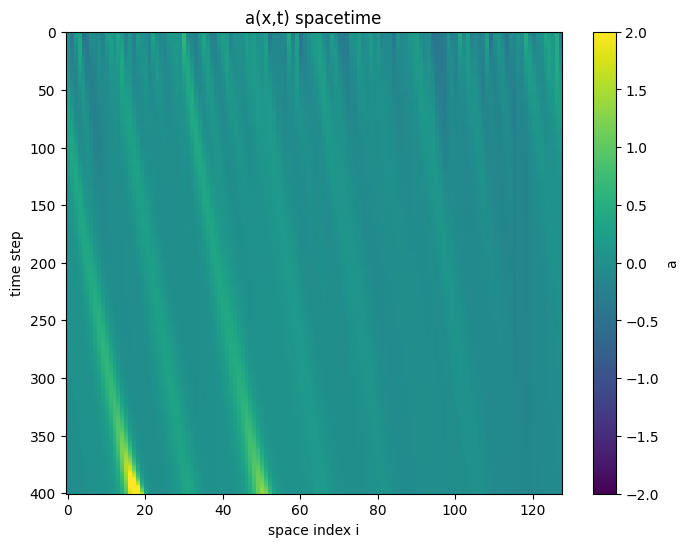

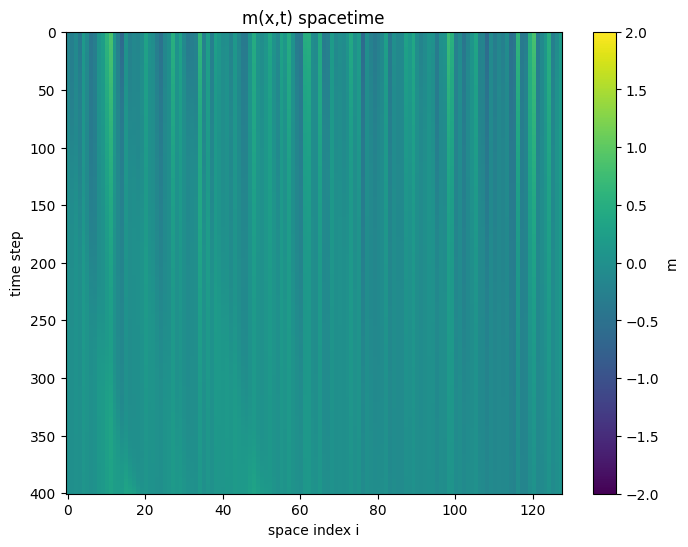

In [116]:
# %% [markdown]
# ## Emergent CA (discrete space, continuous time) — minimal notebook
# Configure parameters & seed here, then run the following cells.
# The model integrates with RK4 and plots a 1-D CA-style spacetime diagram
# for a(t) and m(t): x-axis = space; y-axis (down) = time steps.

# %%
import numpy as np
import random
import matplotlib.pyplot as plt

# ---- Config (edit these) ----
N   = 128          # number of cells (space)
T   = 400          # number of integration steps (time depth)
dt  = 0.05         # time step (continuous-time integrator)

alpha_m = 0.1      # memory leak rate

# Local polynomial coefficients (theta_*):
# dot a_i = theta1 + theta_c*c + theta_l*l + theta_r*r + theta_m*m
#           + theta_cl*c*l + theta_cr*c*r + theta_cm*c*m
theta = {
    "theta1": 0,
    "theta_c": random.uniform(-0.7,0.7),
    "theta_l":  random.uniform(-0.7,0.7),
    "theta_r":  random.uniform(-0.7,0.7),
    "theta_m":  random.uniform(-0.7,0.7),
    "theta_cl": random.uniform(-0.7,0.7),
    "theta_cr": random.uniform(-0.7,0.7),
    "theta_cm": random.uniform(-0.7,0.7),  # small negative to softly saturate at larger amplitudes
}

seed = 42          # RNG seed for reproducible initial state
init_scale = 3e-1  # amplitude of random initialization

# %%
# ---- Dynamics (periodic boundary; RK4 integrator) ----

def deriv(a, m, theta, alpha_m):
    """Compute time-derivatives (dot a, dot m) given current (a, m)."""
    l = np.roll(a, 1)   # a_{i-1}
    r = np.roll(a, -1)  # a_{i+1}
    c = a
    t = theta
    dot_a = (t["theta1"]
             + t["theta_c"]*c + t["theta_l"]*l + t["theta_r"]*r + t["theta_m"]*m
             + t["theta_cl"]*c*l + t["theta_cr"]*c*r + t["theta_cm"]*c*m) - 5*alpha_m*c
    dot_m = alpha_m * (a - m)
    return dot_a, dot_m

def rk4_step(a, m, dt, theta, alpha_m):
    """One RK4 step for the coupled ODEs."""
    k1_a, k1_m = deriv(a, m, theta, alpha_m)
    k2_a, k2_m = deriv(a + 0.5*dt*k1_a, m + 0.5*dt*k1_m, theta, alpha_m)
    k3_a, k3_m = deriv(a + 0.5*dt*k2_a, m + 0.5*dt*k2_m, theta, alpha_m)
    k4_a, k4_m = deriv(a + dt*k3_a,     m + dt*k3_m,     theta, alpha_m)
    a_next = a + (dt/6.0)*(k1_a + 2*k2_a + 2*k3_a + k4_a)
    m_next = m + (dt/6.0)*(k1_m + 2*k2_m + 2*k3_m + k4_m)
    return a_next, m_next

# %%
# ---- Simulation (free evolution, no external input) ----

rng = np.random.default_rng(seed)
a0 = init_scale * rng.standard_normal(N)
m0 = init_scale * rng.standard_normal(N)

A = np.empty((T+1, N), dtype=float)
M = np.empty((T+1, N), dtype=float)
A[0] = a0
M[0] = m0

a, m = a0.copy(), m0.copy()
for t in range(1, T+1):
    a, m = rk4_step(a, m, dt, theta, alpha_m)
    A[t] = a
    M[t] = m

# %%
# ---- Plots: spacetime diagrams (x: space, y: time downwards) ----

plt.figure(figsize=(8, 6))
plt.imshow(A, origin="upper", aspect="auto", interpolation="nearest",vmax=2,vmin=-2)
plt.title("a(x,t) spacetime")
plt.xlabel("space index i")
plt.ylabel("time step")
plt.colorbar(label="a")
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(M, origin="upper", aspect="auto", interpolation="nearest",vmin=-2,vmax=2)
plt.title("m(x,t) spacetime")
plt.xlabel("space index i")
plt.ylabel("time step")
plt.colorbar(label="m")
plt.show()
